In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
# coefficients of the model
a1, a2, a3 = 0.1, -0.2, 4.0
 
# ground truth
A_gt = [a1, a2, a3]
 
print 'A_gt = ', A_gt
 
# create a coordinate matrix
nx = np.linspace(-1, 1, 41)
ny = np.linspace(-1, 1, 41)
x, y = np.meshgrid(nx, ny)
 
# make the estimation
z = a1*x + a2*y + a3

A_gt =  [0.1, -0.2, 4.0]


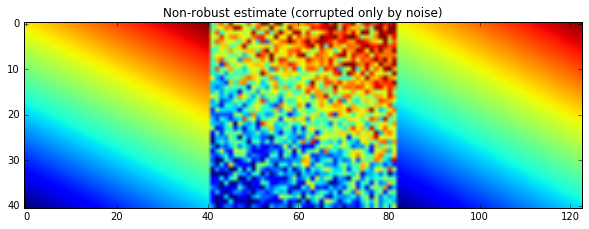

In [13]:
# case 1: data is corrupted by gaussian noise, regular linear least squares method will be used
 
# add some gaussian noise
z_noise = z + 0.1*np.random.standard_normal(z.shape)

# non-robust least squares estimation
# X*A = Z
 
x_fl = x.flatten()
y_fl = y.flatten()
z_ones = np.ones([x.size,1])
 
X = np.hstack((np.reshape(x_fl, ([len(x_fl),1])), np.reshape(y_fl, ([len(y_fl),1])), z_ones))
 
Z = np.zeros(z_noise.shape)
Z[:] = z_noise
Z_fl = Z.flatten()
Z = np.reshape(Z_fl, ([len(Z_fl),1]))
 
A_lsq = np.linalg.lstsq(X,Z)[0]
 
z_least_squares = np.dot(X, A_lsq)
z_least_squares = np.reshape(z_least_squares, z.shape)
 
lsq_non_robust_noise = np.hstack((z, z_noise, z_least_squares))
 
plt.figure(figsize=(10, 10))
plt.title('Non-robust estimate (corrupted only by noise)')
plt.imshow(lsq_non_robust_noise)
plt.clim(z.min(), z.max())

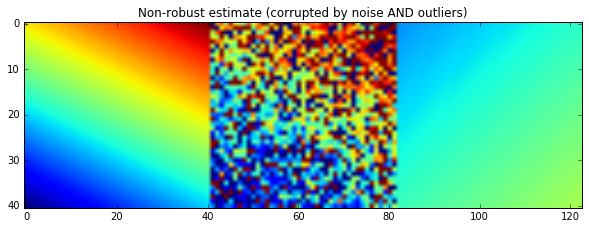

In [28]:
# case 2: data is corrupted by gaussian noise AND outliers, regular linear least squares method will be used
 
# create outliers
outlier_prop = 0.3
outlier_IND = np.random.permutation(x.size)
outlier_IND = outlier_IND[0:int(np.floor(x.size * outlier_prop))]

z_noise_outlier = np.zeros(z_noise.shape)
z_noise_outlier[:] = z_noise
z_noise_outlier_flt = z_noise_outlier.flatten()
 
z_noise_outlier_flt[outlier_IND] = z_noise_outlier_flt[outlier_IND] + 10*np.random.standard_normal(z_noise_outlier_flt[outlier_IND].shape)
z_noise_outlier = np.reshape(z_noise_outlier_flt, z.shape)
 
# non-robust least squares estimation
Z = np.zeros(z_noise_outlier.shape)
Z[:] = z_noise_outlier
Z_fl = Z.flatten()
Z = np.reshape(Z_fl, ([len(Z_fl),1]))
 
A_lsq_outlier = np.linalg.lstsq(X,Z)[0]
 
z_lsq_outlier = np.dot(X, A_lsq_outlier)
z_lsq_outlier = np.reshape(z_lsq_outlier, z.shape)
 
lsq_non_robust_outlier = np.hstack((z, z_noise_outlier, z_lsq_outlier))
 
plt.figure(figsize=(10, 10))
plt.title('Non-robust estimate (corrupted by noise AND outliers)')
plt.imshow(lsq_non_robust_outlier)
plt.clim(z.min(), z.max())

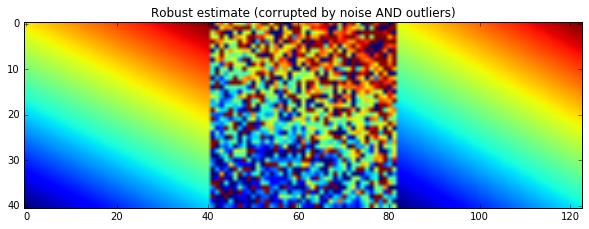

In [29]:
# cased 3: data is corrupted by gaussian noise AND outliers, robust least squares method will be used
 
# robust least sqaures (starting with the least squares solution)
A_robust = A_lsq_outlier
n_robust_it = 10
 
# iterate till the fit converges
for robust_it in range(n_robust_it):
 
  # compute absolute value of residuals (fit minus data)
  abs_resid = abs(np.dot(X, A_robust) - Z)
 
  # compute the scaling factor for the standardization of residuals
  # using the median absolute deviation of the residuals
  # 6.9460 is a tuning constant (4.685/0.6745)
  abs_res_scale = 6.9460 * np.median(abs_resid)
 
  # standardize residuals
  w = abs_resid / abs_res_scale
 
  # compute the robust bisquare weights excluding outliers
  outliers = (w > 1)*1
  w[ outliers.nonzero() ] = 0
 
  good_values = (w != 0)*1
 
  # calculate robust weights for 'good' points
  # Note that if you supply your own regression weight vector,
  # the final weight is the product of the robust weight and the regression weight.
  tmp = 1 - np.power(w[ good_values.nonzero() ], 2)
  w[ good_values.nonzero() ] = np.power(tmp, 2)
 
  # get weighted X'es
  XW = np.tile(w, (1, 3)) * X
 
  a = np.dot(XW.T, X)
  b = np.dot(XW.T, Z)
 
  # get the least-squares solution to a linear matrix equation
  A_robust = np.linalg.lstsq(a,b)[0]
 
  z_robust = np.dot(X, A_robust)
  z_robust = np.reshape(z_robust, z.shape)
 
lsq_robust = np.hstack((z, z_noise_outlier, z_robust))
 
plt.figure(figsize=(10, 10))
plt.title('Robust estimate (corrupted by noise AND outliers)')
plt.imshow(lsq_robust)
plt.clim(z.min(), z.max())